<a href="https://colab.research.google.com/github/gremlin97/EVA-8/blob/main/S6/S6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline

In [42]:
import torch
import torchvision
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [43]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_height=16, min_width=16, min_holes = 1, fill_value=-1.69, mask_fill_value = None),
    A.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5],
    ),
    ToTensorV2()
])

test_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_height=16, min_width=16, min_holes = 1, fill_value=-1.69, mask_fill_value = None),
    A.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5],
    ),
    ToTensorV2()
])

class Cifar10(torchvision.datasets.CIFAR10):
    def __init__(self, root="~/data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

trainset = Cifar10(root='./data', train=True,download=True, transform=train_transform)
testset = Cifar10(root='./data', train=False,download=True, transform=test_transform)

trainloader = torch.utils.data.DataLoader(trainset,batch_size = 4, shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size = 4, shuffle=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [23]:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                         download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
#                                           shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                        download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=4,
#                                          shuffle=False, num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



  car plane   cat  bird


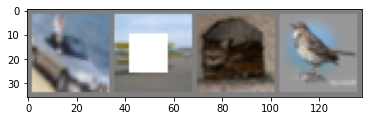

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(iter(dataiter))

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [45]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )
        self.conv2 =  nn.Sequential(
            nn.Conv2d(16, 32, 3, 1, 1,dilation=1), # dilation
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, 1, 1, groups=32), # depthwise-seperable
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.conv3 =  nn.Sequential(
            nn.Conv2d(64, 128, 3, 2, padding=1), # strided
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.conv4 =  nn.Sequential(
            nn.Conv2d(128, 32, 3, 2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.gap = nn.AdaptiveAvgPool2d((1,1)) #gap
        self.fc1 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.gap(x)
        x = x.view(-1,32)
        x = self.fc1(x)
        return x


net = Net()

In [46]:
out = net(torch.randn(1,3,32,32))

In [47]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [48]:
from torchsummary import summary
summary(net.to(device),input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 32, 32, 32]           4,640
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
            Conv2d-7           [-1, 64, 32, 32]             640
              ReLU-8           [-1, 64, 32, 32]               0
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10          [-1, 128, 16, 16]          73,856
             ReLU-11          [-1, 128, 16, 16]               0
      BatchNorm2d-12          [-1, 128, 16, 16]             256
           Conv2d-13             [-1, 32, 8, 8]          36,896
             ReLU-14             [-1, 3

In [49]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [50]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.013
[1,  4000] loss: 1.890
[1,  6000] loss: 1.835
[1,  8000] loss: 1.790
[1, 10000] loss: 1.759
[1, 12000] loss: 1.723
[2,  2000] loss: 1.678
[2,  4000] loss: 1.675
[2,  6000] loss: 1.650
[2,  8000] loss: 1.631
[2, 10000] loss: 1.616
[2, 12000] loss: 1.602
Finished Training


GroundTruth:   bird  ship  frog  bird


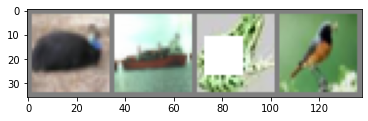

In [51]:
dataiter = iter(testloader)
images, labels = next(iter(dataiter))

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [52]:
outputs = net(images.to(device))

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [53]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  frog  bird


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [54]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 44 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [55]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 56 %
Accuracy of   car : 58 %
Accuracy of  bird : 27 %
Accuracy of   cat : 32 %
Accuracy of  deer : 39 %
Accuracy of   dog : 29 %
Accuracy of  frog : 55 %
Accuracy of horse : 54 %
Accuracy of  ship : 51 %
Accuracy of truck : 45 %
